In [1]:
import pandas as pd
import datetime
import numpy as np
from sklearn.base import clone
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV, cross_val_score, StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from functools import partial
import itertools
from sklift.models import ClassTransformation
import lightgbm as lgbm
import ipywidgets as widgets
import inspect
from datetime import timedelta
from sklearn import preprocessing
import gc
import scipy.stats as st 
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from datetime import date, datetime
import seaborn as sns

In [2]:
import logging

# create logger
logger = logging.getLogger('lg')
logger.setLevel(logging.DEBUG)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

# create formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)

In [3]:
logger.info('info message')

2020-02-19 17:36:59,134 - lg - INFO - info message


# Utils

In [1]:
BASE_TRANSACTION_TEMPLATE = 'base_transaction'
FAVORITES_TEMPLATE = 'favorites'

'''
разделим расчёт фичей на этапы, 
так как совместный расчёт - большая нагрузка на ресурсы.
'''
STEPS_MAPPING = {
    'BASE': (True, 'base_features.csv'),
    'BASE_TRANSACTION': (True, BASE_TRANSACTION_TEMPLATE),
    'FAVORITES': (True, FAVORITES_TEMPLATE),
    'POPULARITY': (True, 'popularity'),
    'ALCO': (True, 'alco'),
    'TIME': (True, 'trans_time'),
    'SVD': (True, 'svd_feature'),
    'STOLEN': (True, 'STOLEN_feature'),
}

In [2]:
def generate_file_name(prefix: str, offset: int):
    '''
    generate name for saving features. 
    
    prefix - feaures name
    offset - offset in days in transactions
    '''
    return '{}_{}.csv'.format(prefix, str(offset))

In [ ]:
def collect_trans(features, offsets, feature_name):
    for offset in offsets:
        offset = offset or ''
        features = features.merge(pd.read_csv(
            generate_file_name(STEPS_MAPPING[feature_name][1], offset), 
            index_col='client_id'), left_index=True, right_index=True, how='left')
        logger.info(features.shape)
    return features

def simple_merge(features, name):
    features = features.merge(
        pd.read_csv(generate_file_name(STEPS_MAPPING[name][1], None), index_col='client_id'), 
        left_index=True, right_index=True, how='left')
    logger.info(features.shape)
    return features

In [6]:
def get_features_from_files(offsets, svdtypes):
    """
    Loads all presaved features. for each offsets.
    
    offsets: list of offsets names for diferend files 
    (base_transaction_14.csv or base_transaction_30.csv) 
    for features with offsets 14 and 30 days
    
    svdtypes: similar as offsets but about targets for svd features
    
    """ 
    features = pd.read_csv(generate_file_name(STEPS_MAPPING['BASE'][1], None), index_col='client_id')
    logger.info(features.shape)

    features = collect_trans(features, offsets, 'BASE_TRANSACTION')
    features = collect_trans(features, offsets, 'FAVORITES')
    features = collect_trans(features, offsets, 'POPULARITY')

    features = simple_merge(features, 'ALCO')
    features = simple_merge(features, 'TIME')

    collect_trans(features, svdtypes, 'SVD')
    features = simple_merge(features, 'STOLEN')
    
    return features

In [ ]:
def save_features_to_file(features, name, offset):
    if STEPS_MAPPING[name][0]:
        features.to_csv(generate_file_name(STEPS_MAPPING[name][1], offset))

In [7]:
def uplift_score(prediction, treatment, target, rate=0.3):
    """
    Подсчет Uplift Score
    """
    order = np.argsort(-prediction)

    treatment_n = int((treatment == 1).sum() * rate)
    treatment_p = target[order][treatment[order] == 1][:treatment_n].mean()

    control_n = int((treatment == 0).sum() * rate)
    control_p = target[order][treatment[order] == 0][:control_n].mean()

    score = treatment_p - control_p
    return score


def get_train_test(features, df_train, df_test):
    logger.info("features index len {}".format(len(features.index)))
    logger.info("train index diff {}".format(len(set(df_train.index) - set(features.index))))
    logger.info("test index diff {}".format(len(set(df_test.index) - set(features.index))))
    return features.loc[df_train.index, :], features.loc[df_test.index, :]

In [8]:
def balance_learn(X_learn, y_learn):
    """
    Балансировка датасета, чтобы пользователей с воздействтием было столько же, 
    сколько пользователей без воздествия
    """
    _, treatment_counts = np.unique(y_learn.treatment_flg, return_counts=True)
    logger.info("{}, {}, {}".format(X_learn.shape, y_learn.shape, treatment_counts[0] - treatment_counts[1]))
    
    treat_learn = y_learn.treatment_flg
    vc = treat_learn.value_counts()
    treat_learn = pd.concat([treat_learn[treat_learn == i].sample(vc.min()) for i in vc.index])

    X_learn = X_learn.loc[treat_learn.index, :]
    y_learn = y_learn.loc[treat_learn.index, :]
    
    _, treatment_counts = np.unique(y_learn.treatment_flg, return_counts=True)
    logger.info("{}, {}, {}".format(X_learn.shape, y_learn.shape, treatment_counts[0] - treatment_counts[1]))
    return X_learn, y_learn

In [9]:
def uplift_score_func(y_true, y_pred, **kwargs):
    return uplift_score(y_pred, treatment=y_true.treatment_flg, target=y_true.target)

In [10]:
class MyClassTransformation(ClassTransformation):
    def fit(self, X, y, estimator_fit_params=None):
        return  super().fit(X, y=y.target, treatment=y.treatment_flg, estimator_fit_params=estimator_fit_params)

In [ ]:
COLUMNS_FOR_POPULARITY = ['brand_id', 'vendor_id', 'segment_id', 'product_id']

In [11]:
def calculate_popularity(products, transactions_with_products):
    
    for col in COLUMNS_FOR_POPULARITY:
        fg = transactions_with_products.drop_duplicates(subset=['client_id', col]) \
                                       .groupby([col]).size().sort_values(ascending=False)
        fg.name = 'popularity_{}'.format(col)

        if col == 'product_id':
            products = products.merge(fg, left_index=True, right_index=True)
        else:
            products = products.join(fg, on=col)
        logger.info('popularity {}'.format(col))
    new_columns = ['popularity_{}'.format(col) for col in COLUMNS_FOR_POPULARITY]
    return transactions_with_products.merge(products[new_columns], left_on='product_id', right_index=True)


def merge_transactions_and_products(products, transactions, calculate_popularity=True):
    transactions_merged = transactions.merge(products, left_on='product_id', right_index=True)
    logger.info('transactions_with_products')
    return calculate_popularity(products, transactions_merged) if calculate_popularity else transactions_merged

In [12]:
def get_transactions(df_purchases, offset=None):
    if not offset:
        return df_purchases

    last_date = df_purchases.date.max()    
    sub_df_purchases = df_purchases[df_purchases.date > last_date-timedelta(days=offset)]
    logger.info("sub_df_purchases shape : {}".format(sub_df_purchases.shape))
    return sub_df_purchases

In [42]:
def filter_correlated_features(data):
    corr = features.corr()
    columns = np.full((corr.shape[0],), True, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i+1, corr.shape[0]):
            if corr.iloc[i,j] >= 0.9:
                if columns[j]:
                    columns[j] = False

    selected_columns = data.columns[columns]
    data = data[selected_columns]
    return data

## Функции для расчёта фичей

In [13]:
def get_products_features(trans):
    columns2 = ['popularity_{}'.format(col) for col in COLUMNS_FOR_POPULARITY]
    total_pop = trans.groupby('client_id')[columns2].sum()
    logger.info(total_pop.columns[0])
    yield total_pop
    
    avg_trans_pop = trans.groupby(['client_id', 'transaction_id'])[columns2].sum().groupby(['client_id'])[columns2].mean()
    avg_trans_pop.columns = ['avg_trans_{}'.format(c) for c in avg_trans_pop.columns]
    logger.info(avg_trans_pop.columns[0])
    yield avg_trans_pop

    total_unique = trans.groupby(['client_id'])[columns].nunique()
    total_unique.columns = ['total_unique_{}'.format(c) for c in total_unique.columns]
    logger.info(total_unique.columns[0])
    yield total_unique

    avg_trans_unique = trans.groupby(['client_id', 'transaction_id'])[columns].nunique().groupby(['client_id'])[columns].mean()
    avg_trans_unique.columns = ['avg_trans_unique_{}'.format(c) for c in avg_trans_unique.columns]
    logger.info(avg_trans_unique.columns[0])
    yield avg_trans_unique
    
    result = []
    for c in COLUMNS_FOR_POPULARITY[:-1]:
        fc = trans.groupby(['client_id', c])['product_id'].nunique().groupby(['client_id']).mean()
        fc.name = 'avg_nunique_prod_in_{}'.format(c)
        result.append(fc)
    avg_nunique_prod = pd.concat(result, axis=1, sort=False)
    logger.info(avg_nunique_prod.columns[0])
    yield avg_nunique_prod

In [14]:
def pop_features(offset):
    offset = offset or ''
    final = None
    for df in get_products_features(df_purchases):    
        final = final.merge(df, left_index=True, right_index=True) if final is not None else df
    final.index.name = 'client_id'
    save_features_to_file(final, 'POPULARITY', offset)
    return final

In [15]:
def base_features(clean=True):
    df_features = pd.read_csv('data/clients.csv', index_col='client_id', parse_dates=['first_issue_date','first_redeem_date'])
    df_features['gender'] = LabelEncoder().fit_transform(df_features.gender)
    df_features['first_issue_date_weekday'] = df_features['first_issue_date'].dt.weekday
    df_features['first_redeem_date_weekday'] = df_features['first_redeem_date'].dt.weekday
    df_features['first_issue_date_hour'] = df_features['first_issue_date'].dt.hour
    df_features['first_redeem_date_hour'] = df_features['first_redeem_date'].dt.hour

    # we need more redeem date features
    df_features['redeem_date_mo'] = df_features['first_redeem_date'].dt.month  
    df_features['redeem_date_week'] = df_features['first_redeem_date'].dt.week
    df_features['redeem_date_doy'] = df_features['first_redeem_date'].dt.dayofyear
    df_features['redeem_date_q'] = df_features['first_redeem_date'].dt.quarter
    df_features['redeem_date_ms'] = df_features['first_redeem_date'].dt.is_month_start
    df_features['redeem_date_me'] = df_features['first_redeem_date'].dt.is_month_end

    df_features['first_issue_time'] = pd.to_datetime(df_features['first_issue_date']).astype(int) / 10 ** 9
    df_features['first_redeem_time'] = pd.to_datetime(df_features['first_redeem_date']).astype(int) / 10 ** 9
    df_features['issue_redeem_delay'] = df_features['first_redeem_time'] - df_features['first_issue_time']

    df_features['first_issue_date'] = df_features['first_issue_date'].apply(lambda x: date.toordinal(x))
    df_features['first_redeem_date'] = df_features['first_redeem_date'].apply(lambda x: date.toordinal(x))
    
    cutoff_dt = date.toordinal(date(2019, 3, 19))
    df_features['issue_diff'] = cutoff_dt - df_features['first_issue_date']
    df_features['redeem_diff'] = cutoff_dt - df_features['first_redeem_date']
    df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)
        
    save_features_to_file(df_features, 'BASE', None)

    if clean:
        del df_features
        gc.collect()
        return

    return df_features

In [16]:
def transactions_features(transactions, offset=None, clean=True):
    offset = offset or ''
    last_cols = [
        'regular_points_received', 
        'express_points_received',
        'regular_points_spent',
        'express_points_spent',
        'purchase_sum'
    ]

    logger.info("Create history")
    history = transactions.groupby(['client_id', 'transaction_id'])[last_cols].last()
    
    logger.info("Create _features")
    _features = [
        (history.groupby('client_id')['purchase_sum'].count(), ['total_trans_count']), 
        (history.groupby('client_id').sum(), last_cols)
    ]
    
    _features = list(zip(*_features))
    transactions_features =  pd.concat(_features[0], axis = 1)
    transactions_features.columns = list(itertools.chain.from_iterable(_features[1]))
    transactions_features.columns = ['days_{}_'.format(str(offset)) + c for c in transactions_features.columns]

    save_features_to_file(transactions_features, 'BASE_TRANSACTION', offset)
    if clean:
        del transactions_features
        gc.collect()
        return
    
    return transactions_features

In [17]:
def favorite_products_features(merged_transactions, offset=None, clean=True):
    offset = offset or ''
    # вычисляем любимый продукт/категорию/сегмент для каждого юзера.
    cols = ['product_id', 'brand_id', 'vendor_id', 'segment_id']
    result = []
    for c in cols:
        logger.info("favorite {}".format(c))
        result.append(
            merged_transactions.groupby(['client_id', c]).size().reset_index(name='counts').groupby(['client_id']).max()[c]
        )

    favorites = pd.concat(result, axis=1, sort=False)
    favorites.columns = [str(offset) + '_faivorite_' + c for c in cols]
    favorites.index.name = 'client_id'

    for col in favorites.columns:
        logger.info('LabelEncoder for {}'.format(col))
        favorites[col] = LabelEncoder().fit_transform(favorites[col].astype(str))    

    save_features_to_file(favorites, 'FAVORITES', offset)
    if clean:
        del favorites
        gc.collect()
        return        
        
    return favorites

In [20]:
def prepare_data_for_alcohol_and_trade_mark(df_products, df_purchases):
    return df_purchases[[
        "client_id", 
        "product_id"
    ]].merge(
        df_products[["is_own_trademark","is_alcohol"]], 
        left_on='product_id', right_index=True)

def agg_alco_features(alk_dt, columns):
    tmp = alk_dt.groupby(columns).agg({
    'product_id' : 'count', 
    'is_alcohol' : 'sum', 
    'is_own_trademark' : 'sum'})
    tmp['part_own_trademark'] = tmp.is_own_trademark / tmp.product_id
    tmp['part_is_alcohol'] = tmp.is_alcohol / tmp.product_id
    
    return_columns = ['is_own_trademark', 'part_own_trademark', 'is_alcohol', 'part_is_alcohol']
    if len(columns) > 1:
        result = tmp.groupby(columns[:1:]).mean()[return_columns]
        result.columns = ['trans_avg_{}'.format(c) for c in return_columns]
    else:
        result = tmp[return_columns]
    
    return  result

In [18]:
def generate_the_first_part_of_features(offset, df_products, df_purchases):
    sb_df_purchases = get_transactions(df_purchases, offset=offset)
    transactions_features(sb_df_purchases, offset=offset)
    sb_df_purchases = merge_transactions_and_products(df_products, sb_df_purchases)
    favorite_products_features(merged_transactions=sb_df_purchases, offset=offset)

In [21]:
def prepare_alco_features():
    alco_data = prepare_data_for_alcohol_and_trade_mark(df_products, df_purchases)
    avg_trans_features = agg_alco_features(alco_data, ['client_id', 'transaction_id'])
    history_features = agg_alco_features(alco_data, ['client_id'])
    alco_features = avg_trans_features.merge(history_features, left_index=True, right_index=True)
    save_features_to_file(alco_features, 'ALCO', None)
    return alco_features

In [22]:
def prepare_timeseries_features(df_purchases):
    df_purchases = df_purchases[['client_id', 'date']].drop_duplicates().sort_values(['client_id', 'date'])
    df_purchases['Time Delta'] = np.where(
        df_purchases['client_id'] == df_purchases['client_id'].shift(), 
        df_purchases['date'] - df_purchases['date'].shift(1), np.nan)
    df_purchases['td_ints'] = df_purchases['Time Delta'].apply(lambda x: x.days)
    
    max_date = df_purchases.date.max()
    avg_trans_diff = df_purchases.groupby(['client_id'])['td_ints'].mean()
    max_trans_diff = df_purchases.groupby(['client_id'])['td_ints'].max()
    min_trans_diff = df_purchases.groupby(['client_id'])['td_ints'].min()
    max_user_date = max_date - df_purchases.groupby(['client_id'])['date'].max()
    min_user_date = max_date - df_purchases.groupby(['client_id'])['date'].min()
    user_diff = min_user_date - max_user_date 
    res = pd.concat([
        avg_trans_diff,
        max_trans_diff,
        min_trans_diff,
        max_user_date,
        min_user_date,
        user_diff], axis = 1)
    res.columns = [
        'avg_trans_diff',
        'max_trans_diff',
        'min_trans_diff',
        'max_user_date',
        'min_user_date',
        'user_diff']
    for c in ['max_user_date', 'min_user_date', 'user_diff']:
        res[c] = res[c].apply(lambda x: x.days)
    
    save_features_to_file(res, 'TIME', None)

In [24]:
def aggregate_user_prod(X, target_field='product_id', date_field=None, weighted_field=None, weighted=None, date_format=None):
    """Grop users and targets for user target matrix

        :param X: incoming data for fitting
        :type X: pd.DataFrame
        :param date_field: field name for date
        :param weighted_field: field name to use during weighting transactions.
        :type weighted_field: str.
        :param weighted: type of weighting transactions. Choices are:
            None -- not weighted
            0 -- date
            1 -- quantity
            2 -- date & quantity
        :type weighted: str.
        :param date_format: time format string
        :type date_format: str.
    """
    value_field = 'value'
    select_fields = ['client_id', target_field]
    if date_field:
        select_fields.append(date_field)
    if weighted_field:
        select_fields.append(weighted_field)
    X = X.loc[:, select_fields]

    if weighted in [0, 1, 2]:
        if weighted in [0, 2]:
            X[date_field] = pd.to_datetime(X[date_field], format=date_format).astype('int')
            max_data = X[date_field].max()
            min_data = X[date_field].min()
            X[value_field] = X[date_field].apply(lambda x: np.exp((x - max_data) / (max_data - min_data)))
            if weighted == 2 and weighted_field:
                X[weighted_field] = X[weighted_field].astype('float')
                X[value_field] *= X[weighted_field]
        if weighted == 1 and weighted_field:
            X[value_field] = None
            X[value_field] = X[weighted_field].astype('float')
    else:
        X.loc[X.index, value_field] = 1

    X = X.groupby(['client_id', target_field]).sum()
    X.reset_index(inplace=True)
    return X

In [25]:
def convert_to_idx_encodings(X):
    """Convert field values to their integer encodings (in the index)

    :param X: column with values for convertion
    :type X: pd.Series
    :return: index to position, position to index, position
    :rtype: Tuple[dict, np.array, pd.Series]
    """
    pos2index = X.unique()
    index2pos = {idx: i for i, idx in enumerate(pos2index)}
    pos = X.apply(lambda s: index2pos[s])
    return index2pos, pos2index, pos

In [26]:
def get_svd_repres(X, user_field, target_field, value_field):
    row_index2pos, row_pos2index, row_pos = convert_to_idx_encodings(X[user_field])
    col_index2pos, col_pos2index, col_pos = convert_to_idx_encodings(X[target_field])

    nrows = row_pos2index.shape[0]
    ncols = col_pos2index.shape[0]

    logger.info("Creating sparce matrix...")
    matrix = csr_matrix((X[value_field], (row_pos, col_pos)), shape=(nrows, ncols))
    logger.info("Sparse matrix size: {} ".format(matrix.shape))

    user_index = row_pos2index
    prom_index = col_pos2index
    logger.info("Fitting model...")
    n_components = 30
    model = TruncatedSVD(**{
            'random_state': 12345,
            'algorithm': 'randomized', ## R-SVD
            'n_iter': 15,
            'n_components': n_components
        })
    model.fit(matrix)    
    ## n_users x k
    reprs = pd.DataFrame(model.transform(matrix))
    reprs.columns = ['{}_{}'.format(target_field, i) for i in range(n_components)]
    reprs.index = user_index
    reprs.index.name = user_field
    
    save_features_to_file(reprs, 'SVD', target_field)
    return reprs


In [27]:
def calculte_svd_features_for_targets(targets):
    for target_field in targets:
        aggregated = aggregate_user_prod(
            df_purchases, 
            target_field=target_field, 
            date_field='date', 
            weighted_field='product_quantity', 
            weighted=2, 
            date_format='%Y-%m-%d'
        )
        X_user_repres = get_svd_repres(
            aggregated, 
            user_field='client_id', 
            target_field=target_field, 
            value_field='value'
        )

In [28]:
# tagrets = ['product_id', 'brand_id', 'vendor_id', 'segment_id', 'store_id']
tagrets = ['product_id', 'brand_id', 'vendor_id']

# run features calculation

In [23]:
# df_products = pd.read_csv('data/products.csv', index_col='product_id')
# logger.info("df_products shape {}".format(df_products.shape))

# # df_purchases = pd.read_csv('data/purchases.csv', index_col='transaction_id', parse_dates=['transaction_datetime'], nrows=100000)
# # # df_purchases = pd.read_csv('data/purchases.csv', index_col='transaction_id', parse_dates=['transaction_datetime'])

# # df_purchases = pd.read_csv('data/purchases.csv', parse_dates=['transaction_datetime'], nrows=100000)
# df_purchases = pd.read_csv('data/purchases.csv', parse_dates=['transaction_datetime'])

# df_purchases['date'] = df_purchases['transaction_datetime'].dt.date
# logger.info("df_purchases shape {}".format(df_purchases.shape))

In [29]:
# df_purchases = merge_transactions_and_products(df_products, df_purchases, calculate_popularity=False)
# calculte_svd_features_for_targets(tagrets)

In [30]:
# prepare_timeseries_features(df_purchases)

In [31]:
# base_features();

In [32]:
# offets = [None]
# for offst in offets:
#     logger.info('{} offst = {}'.format('--'*30, offst))
#     generate_the_first_part_of_features(offst, df_products, df_purchases);

In [33]:
# offset = 14
# df_purchases = merge_transactions_and_products(df_products, get_transactions(df_purchases, offset=offset))
# tpf = pop_features(offset)

In [34]:
# prepare_alco_features()

# stolen features

In [36]:
# Calculate number and amount of purhases before and after the 1st redeem date across all clients
#
def calc_purchases_around_dates(df_clients, df):
    
    df['redeem_ord'] = df['first_redeem_date'].apply(lambda x: date.toordinal(x))
    df['purch_ord'] = df['transaction_datetime'].apply(lambda x: date.toordinal(x))
    df['ord_diff'] = df['redeem_ord'] - df['purch_ord']

    df_before = df[df['ord_diff'] > 0][['client_id', 'transaction_id', 'purchase_sum']]
    df_after = df[df['ord_diff'] <= 0][['client_id', 'transaction_id', 'purchase_sum']]
    
    df_before_all = df_before.groupby(['client_id', 'transaction_id']).last()
    df_after_all = df_after.groupby(['client_id', 'transaction_id']).last()

    ds_before_sum = df_before_all.groupby('client_id')['purchase_sum'].sum()
    ds_after_sum = df_after_all.groupby('client_id')['purchase_sum'].sum()

    ds_before_counters = df_before_all.groupby('client_id')['purchase_sum'].count()    
    ds_after_counters = df_after_all.groupby('client_id')['purchase_sum'].count()    

    ds_before_sum.name = 'before_redeem_sum'
    ds_after_sum.name = 'after_redeem_sum'

    ds_before_counters.name = 'before_redeem_counter'
    ds_after_counters.name = 'after_redeem_counter'

    features = pd.merge(df_clients, ds_after_sum, how='left', on='client_id')    
    features = pd.merge(features, ds_after_sum, how='left', on='client_id')    
    features = pd.merge(features, ds_before_counters, how='left', on='client_id')    
    features = pd.merge(features, ds_after_counters, how='left', on='client_id')
    
    for i in range(7):
        logger.info("day {}".format(i))
        df_dayfiltered = df[df['purch_weekday'] == i][[
            'client_id', 'transaction_id', 'purch_weekday', 'trn_sum_from_iss']]
        ds_purch_dow = df_dayfiltered.groupby(['client_id', 'transaction_id']).last()
        ds_counters = ds_purch_dow.groupby('client_id')['purch_weekday'].count()
        # DOW = day of week
        ds_counters.name = 'purch_dow_{}'.format(i)
        features = pd.merge(features, ds_counters, how='left', on='client_id')

        ds_purch_dow = df_dayfiltered.groupby('client_id')['trn_sum_from_iss'].sum()
        ds_counters.name = 'purch_sum_dow_{}'.format(i)
        features = pd.merge(features, ds_counters, how='left', on='client_id')

    for i in range(24):
        logger.info("hour {}".format(i))
        df_dayfiltered = df[df['purch_hour'] == i][['client_id', 'transaction_id', 'purch_hour']]
        ds_purch_hour = df_dayfiltered.groupby(['client_id', 'transaction_id']).last()
        ds_counters = ds_purch_hour.groupby('client_id')['purch_hour'].count()
        ds_counters.name = 'purch_hour_{}'.format(i)
        features = pd.merge(features, ds_counters, how='left', on='client_id')

    save_features_to_file(features, 'STOLEN', None)
       
    return features

In [37]:
# df_clients = pd.read_csv('data/clients.csv', index_col='client_id', parse_dates=['first_issue_date','first_redeem_date'])
# df_purchases['purch_weekday'] = df_purchases['transaction_datetime'].dt.weekday
# df_purchases['purch_hour'] = df_purchases['transaction_datetime'].dt.hour
# df_purchases['purch_day'] = df_purchases['transaction_datetime'].apply(lambda x: date.toordinal(x))
# df_purchase_detailed = pd.merge(df_purchases, df_clients, how='left', on='client_id')
# res = calc_purchases_around_dates(df_clients, df_purchase_detailed)

#  read pre-calculated features

In [39]:
offets = [14, 30, None]
features = get_features_from_files(offets, svdtypes=tagrets)
features = features.drop(list(filter(lambda x: x.endswith('_y'), list(features.columns))), axis=1)

2020-02-19 17:37:02,553 - lg - INFO - (400162, 19)
2020-02-19 17:37:04,393 - lg - INFO - (400162, 25)
2020-02-19 17:37:04,551 - lg - INFO - (400162, 31)
2020-02-19 17:37:04,702 - lg - INFO - (400162, 37)
2020-02-19 17:37:06,078 - lg - INFO - (400162, 41)
2020-02-19 17:37:06,226 - lg - INFO - (400162, 45)
2020-02-19 17:37:06,378 - lg - INFO - (400162, 49)
2020-02-19 17:37:10,774 - lg - INFO - (400162, 68)
2020-02-19 17:37:11,046 - lg - INFO - (400162, 87)
2020-02-19 17:37:11,263 - lg - INFO - (400162, 106)
2020-02-19 17:37:12,298 - lg - INFO - (400162, 114)
2020-02-19 17:37:13,043 - lg - INFO - (400162, 120)
2020-02-19 17:37:25,061 - lg - INFO - (400162, 150)
2020-02-19 17:37:25,391 - lg - INFO - (400162, 180)
2020-02-19 17:37:25,737 - lg - INFO - (400162, 210)
2020-02-19 17:37:28,461 - lg - INFO - (400162, 256)


In [40]:
features.head()

,first_issue_date_x,first_redeem_date_x,age_x,gender_x,first_issue_date_weekday,first_redeem_date_weekday,first_issue_date_hour,first_redeem_date_hour,redeem_date_mo,redeem_date_week,...,purch_hour_14,purch_hour_15,purch_hour_16,purch_hour_17,purch_hour_18,purch_hour_19,purch_hour_20,purch_hour_21,purch_hour_22,purch_hour_23
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,736546,736698,45,2,5,3.0,15,19.0,1.0,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000036f903,736429,736442,72,0,0,6.0,13,12.0,4.0,16.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000048b7a6,737043,1,68,0,5,NaN,13,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000073194a,736472,736657,60,0,1,4.0,12,11.0,11.0,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00007c7133,736471,737059,67,2,0,0.0,16,17.0,12.0,1.0,...,3.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
features.shape

(400162, 251)

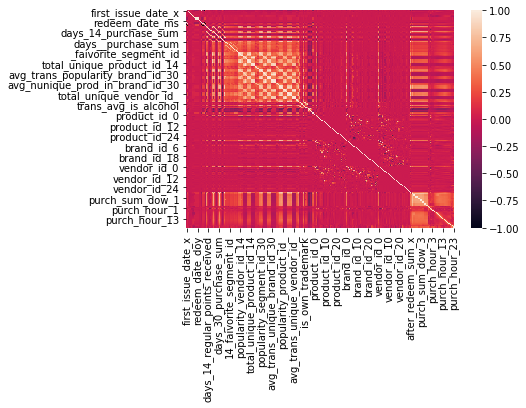

In [44]:
corr = features.corr()
sns.heatmap(corr)

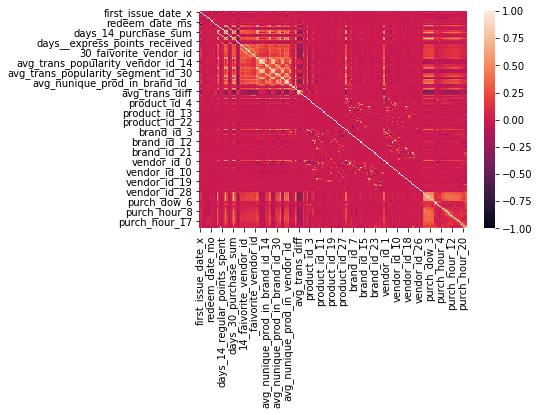

In [45]:
features = filter_correlated_features(features)
corr = features.corr()
sns.heatmap(corr)

# Уберём фичи с большим количеством пропусков

In [47]:
nans_count = features.isna().sum()
filtered = nans_count[nans_count != 0].sort_values()

In [46]:
features.shape

(400162, 196)

In [48]:
features = features.drop(filtered[filtered > 10000].index, axis=1)

In [49]:
features.shape

(400162, 142)

In [50]:
nans_count = features.isna().sum()
filtered = nans_count[nans_count != 0].sort_values()

In [51]:
filtered

popularity_brand_id_30                   1
popularity_product_id_30                 1
avg_trans_popularity_brand_id_30         1
avg_trans_popularity_segment_id_30       1
avg_trans_popularity_product_id_30       1
avg_nunique_prod_in_vendor_id_30         1
avg_nunique_prod_in_segment_id_         28
brand_id_14                             45
brand_id_15                             45
brand_id_16                             45
brand_id_17                             45
brand_id_18                             45
brand_id_19                             45
brand_id_20                             45
brand_id_23                             45
brand_id_22                             45
brand_id_13                             45
brand_id_24                             45
brand_id_25                             45
brand_id_26                             45
brand_id_27                             45
brand_id_21                             45
brand_id_12                             45
brand_id_9 

In [52]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
columns = features.columns
index = features.index
imputer = ColumnTransformer(transformers=[
    ('imputer_mean_or_median', SimpleImputer(missing_values=np.nan, strategy='median'), columns),
])

In [53]:
imputer.fit(features)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('imputer_mean_or_median',
                                 SimpleImputer(add_indicator=False, copy=True,
                                               fill_value=None,
                                               missing_values=nan,
                                               strategy='median', verbose=0),
                                 Index(['first_issue_date_x', 'first_redeem_date_x', 'age_x', 'gender_x',
       'first_issue_date_weekday', 'first_issue_date_hour', 'redeem_date_ms',
       'redeem_date_me', 'issue_diff', 'redeem_diff',
       ...
       'vendor_id_20', 'vendor_id_21', 'vendor_id_22', 'vendor_id_23',
       'vendor_id_24', 'vendor_id_25', 'vendor_id_26', 'vendor_id_27',
       'vendor_id_28', 'vendor_id_29'],
      dtype='object', length=142))],
                  verbose=False)

In [55]:
features = pd.DataFrame(imputer.transform(features), columns=columns)
features.index = index

In [56]:
features.head()

,first_issue_date_x,first_redeem_date_x,age_x,gender_x,first_issue_date_weekday,first_issue_date_hour,redeem_date_ms,redeem_date_me,issue_diff,redeem_diff,...,vendor_id_20,vendor_id_21,vendor_id_22,vendor_id_23,vendor_id_24,vendor_id_25,vendor_id_26,vendor_id_27,vendor_id_28,vendor_id_29
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,736546.0,736698.0,45.0,2.0,5.0,15.0,0.0,0.0,591.0,439.0,...,-0.034534,-0.041156,-0.296206,0.133315,0.195216,0.018048,0.069514,-0.920269,-0.914800,-0.169801
000036f903,736429.0,736442.0,72.0,0.0,0.0,13.0,0.0,0.0,708.0,695.0,...,-2.105161,1.624794,-1.227649,-5.404261,-5.069269,-0.015040,6.600822,9.417289,-3.727393,5.716118
000048b7a6,737043.0,1.0,68.0,0.0,5.0,13.0,0.0,0.0,94.0,737136.0,...,-0.063752,0.009250,-0.225258,0.117951,-0.183025,-0.032410,-0.132880,0.107378,-0.035602,-0.271495
000073194a,736472.0,736657.0,60.0,0.0,1.0,12.0,0.0,0.0,665.0,480.0,...,-0.189796,0.080843,0.437897,-0.175441,0.128464,0.117221,0.931019,0.233715,-0.175856,-2.394835
00007c7133,736471.0,737059.0,67.0,2.0,0.0,16.0,0.0,1.0,666.0,78.0,...,-0.145124,0.131544,0.242656,-0.134211,0.013960,0.003753,-0.301761,-0.258990,0.105565,-0.085076


In [57]:
features.shape

(400162, 142)

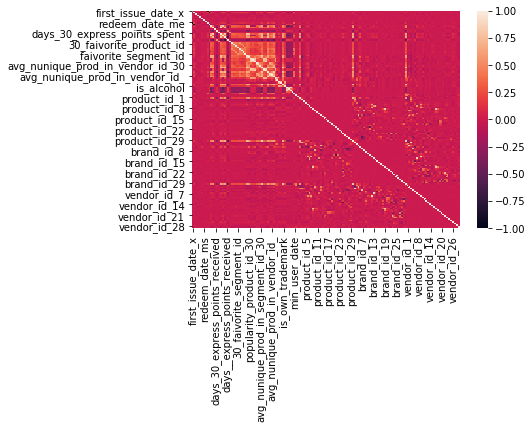

In [58]:
corr = features.corr()
sns.heatmap(corr)

# разделим данные, чтобы обучить модель

In [59]:
df_clients = pd.read_csv('data/clients.csv', index_col='client_id', parse_dates=['first_issue_date','first_redeem_date'])

In [60]:
df_train = pd.read_csv('data/uplift_train.csv', index_col='client_id')
logger.info(df_train.shape)

df_test = pd.read_csv('data/uplift_test.csv', index_col='client_id')
logger.info(df_test.shape)

2020-02-19 17:41:49,700 - lg - INFO - (200039, 2)
2020-02-19 17:41:49,838 - lg - INFO - (200123, 0)


In [61]:
x_train, x_test = get_train_test(features, df_train, df_test)

2020-02-19 17:41:49,847 - lg - INFO - features index len 400162
2020-02-19 17:41:50,022 - lg - INFO - train index diff 0
2020-02-19 17:41:50,164 - lg - INFO - test index diff 0


In [62]:
x_train.shape

(200039, 142)

In [63]:
x_test.shape

(200123, 142)

In [64]:
indices_learn, indices_valid = train_test_split(x_train.index, test_size=0.3)

In [65]:
X_learn = x_train.loc[indices_learn, :]
y_learn = df_train.loc[indices_learn, :]

X_val = x_train.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, :]

In [66]:
params = {'learning_rate':0.01,'max_depth':3,'num_leaves':20,
             'min_data_in_leaf':3, 'application':'binary', 'subsample':0.8, 'colsample_bytree': 0.8,
             'reg_alpha':0.01,'data_random_seed':1, 'metric':'binary_logloss',
             'max_bin':416,'bagging_freq':3,'reg_lambda':0.01, 'class_weight': 'balanced',             
    }

In [67]:
matrix = lgbm.Dataset(X_learn, label=y_learn.target)
cv_result = lgbm.cv(params, matrix, num_boost_round=1500,nfold=5, stratified=True, 
                    shuffle=True, early_stopping_rounds=50, verbose_eval=50)

[50]	cv_agg's binary_logloss: 0.599631 + 0.000402177
[100]	cv_agg's binary_logloss: 0.570802 + 0.000650318
[150]	cv_agg's binary_logloss: 0.55699 + 0.000899375
[200]	cv_agg's binary_logloss: 0.549803 + 0.00107137
[250]	cv_agg's binary_logloss: 0.54575 + 0.00115467
[300]	cv_agg's binary_logloss: 0.543399 + 0.00123338
[350]	cv_agg's binary_logloss: 0.541532 + 0.00129342
[400]	cv_agg's binary_logloss: 0.539595 + 0.00150515
[450]	cv_agg's binary_logloss: 0.537658 + 0.00159615
[500]	cv_agg's binary_logloss: 0.536261 + 0.00162461
[550]	cv_agg's binary_logloss: 0.535474 + 0.00173397
[600]	cv_agg's binary_logloss: 0.534627 + 0.00178573
[650]	cv_agg's binary_logloss: 0.534116 + 0.00178014
[700]	cv_agg's binary_logloss: 0.533729 + 0.00187668
[750]	cv_agg's binary_logloss: 0.533394 + 0.00185257
[800]	cv_agg's binary_logloss: 0.533159 + 0.00187731
[850]	cv_agg's binary_logloss: 0.53294 + 0.00188876
[900]	cv_agg's binary_logloss: 0.532787 + 0.00185907
[950]	cv_agg's binary_logloss: 0.532648 + 0.001

In [68]:
len(cv_result['binary_logloss-mean'])

1500

In [69]:
params['n_estimators'] = len(cv_result['binary_logloss-mean'])

In [70]:
from sklearn.metrics import make_scorer
parameters = {
#     'classifier__estimator__num_leaves': list(range(20, 50, 15)),
#     'classifier__estimator__min_child_samples': list(range(20, 50, 15)),
#     'classifier__estimator__class_weight': ['balanced', None]

}
modelcv = GridSearchCV(
    Pipeline(steps=[
        ('classifier', MyClassTransformation(lgbm.LGBMClassifier(**params)))
    ]),
    parameters,
    scoring=make_scorer(uplift_score_func), 
    cv=ShuffleSplit(n_splits=4, test_size=0.3, random_state=12), 
    verbose=3, n_jobs=-1
)
modelcv.fit(X_learn, y_learn);

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  1.9min finished
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  app.launch_new_instance()


In [71]:
modelcv.best_estimator_

Pipeline(memory=None,
         steps=[('classifier',
                 MyClassTransformation(estimator=LGBMClassifier(application='binary',
                                                                bagging_freq=3,
                                                                boosting_type='gbdt',
                                                                class_weight='balanced',
                                                                colsample_bytree=0.8,
                                                                data_random_seed=1,
                                                                importance_type='split',
                                                                learning_rate=0.01,
                                                                max_bin=416,
                                                                max_depth=3,
                                                                metric='binary_logloss',
                    

In [72]:
modelcv.best_score_

0.07171409798206124

In [73]:
final_model = modelcv.best_estimator_

In [74]:
print('Validation score:', uplift_score(final_model.predict(X_val), treatment=y_val.treatment_flg, target=y_val.target))

Validation score: 0.08514091388942169


# Подготовка предсказаний для тестовых клиентов

In [75]:
x_train, df_train = balance_learn(x_train, df_train)

2020-02-19 17:47:24,757 - lg - INFO - (200039, 142), (200039, 2), 77
2020-02-19 17:47:25,253 - lg - INFO - (199962, 142), (199962, 2), 0


In [76]:
final_model.fit(x_train, df_train)

Pipeline(memory=None,
         steps=[('classifier',
                 MyClassTransformation(estimator=LGBMClassifier(application='binary',
                                                                bagging_freq=3,
                                                                boosting_type='gbdt',
                                                                class_weight='balanced',
                                                                colsample_bytree=0.8,
                                                                data_random_seed=1,
                                                                importance_type='split',
                                                                learning_rate=0.01,
                                                                max_bin=416,
                                                                max_depth=3,
                                                                metric='binary_logloss',
                    

In [77]:
upl_sc = final_model.predict(x_test)
pd.DataFrame({'client_id':x_test.index.values,'uplift': upl_sc}).to_csv('final_score_only_my_3_with_out_cor.csv')

In [78]:
fi = pd.DataFrame({
    'feature_score': final_model.steps[0][1].estimator.feature_importances_
}, index=x_train.columns).sort_values('feature_score')

In [79]:
%matplotlib inline

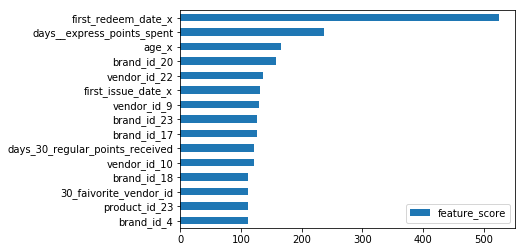

In [80]:
ax = fi.tail(15).plot.barh()

### вычислим доверительный интервал оценки прогноза, чтобы по Public отсеживать overfit 

In [81]:
scores = cross_val_score(
    final_model, x_train, df_train,
    cv=ShuffleSplit(n_splits=10, test_size=0.3), 
    scoring=make_scorer(uplift_score_func)
)
scores

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  app.launch_new_instance()


array([0.07606496, 0.07471136, 0.08310397, 0.08730548, 0.07108468,
       0.07045726, 0.07069083, 0.07301913, 0.06525973, 0.09108545])

In [82]:
np.mean(scores), st.sem(scores)

(0.07627828458517966, 0.0026120446982141428)

In [83]:
st.t.interval(0.95, len(scores)-1, loc=np.mean(scores), scale=st.sem(scores)) 

(0.0703694289617149, 0.08218714020864441)